<h1>Output from OSA/spi_grb_analysis tool and spectral fit:</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from matplotlib import colors

import emcee, time
from tqdm.autonotebook import tqdm as tqdm
import corner

from spectral_shapes import cutoff_powerlaw
from priors import *

plt.style.use('thomas')

/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
plt.style.use('thomas')

<h3>Spectrum fits file as output from spimodfit:</h3>

In [3]:
smf_run = 'fit_GRB120711A_BB_SwiftPosition_spec/'

In [4]:
spec = fits.open(smf_run+'spectra_GRB.fits')

In [5]:
spec.info()

Filename: fit_GRB120711A_BB_SwiftPosition_spec/spectra_GRB.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     34   1R x 6C   [8A, 32A, 1J, 1J, 256A, 3A]   
  2  SPI.-PHA1-SPE    1 BinTableHDU    117   32R x 8C   [1I, 1E, 1E, 1E, 1I, 1I, 1E, 1E]   


<h3>RMF file as output from a spimodfit script (cf. spimodfit_rmfgen.csh)</h3>

In [6]:
rmf = fits.open(smf_run+'spectral_response.rmf.fits')

In [7]:
rmf.info()

Filename: fit_GRB120711A_BB_SwiftPosition_spec/spectral_response.rmf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     50   2R x 9C   [8A, 32A, 1J, 1J, 256A, 3A, 1I, 1D, 1D]   
  2  SPI.-RMF.-RSP    1 BinTableHDU     46   320R x 6C   [1E, 1E, 1I, 1I, 1I, 1PE(32)]   
  3  SPI.-EBDS-SET    1 BinTableHDU     39   32R x 3C   [1J, 1E, 1E]   


In [8]:
rmf[3].columns

ColDefs(
    name = 'CHANNEL'; format = '1J'
    name = 'E_MIN'; format = '1E'; unit = 'keV'
    name = 'E_MAX'; format = '1E'; unit = 'keV'
)

In [9]:
rmf[2].columns

ColDefs(
    name = 'ENERG_LO'; format = '1E'; unit = 'keV'
    name = 'ENERG_HI'; format = '1E'; unit = 'keV'
    name = 'N_GRP'; format = '1I'
    name = 'F_CHAN'; format = '1I'
    name = 'N_CHAN'; format = '1I'
    name = 'MATRIX'; format = '1PE(32)'
)

<h3>Defining RMF energies and redistribution matrix:</h3>

In [10]:
elo = rmf[2].data['ENERG_LO']
ehi = rmf[2].data['ENERG_HI']
mat = rmf[2].data['MATRIX']

In [11]:
rsp_file = smf_run+'spectral_response.rmf.fits'
hdul = fits.open(rsp_file)
e_min = hdul['SPI.-EBDS-SET'].data['E_MIN']
e_max = hdul['SPI.-EBDS-SET'].data['E_MAX']
ee = (e_max+e_min)/2. # centre of the bin
dee = (e_max-e_min)   # bin size
e_lo = hdul['SPI.-RMF.-RSP'].data['ENERG_LO']
e_hi = hdul['SPI.-RMF.-RSP'].data['ENERG_HI']
e_mean = (e_hi+e_lo)/2.
de = (e_hi-e_lo)

In [12]:
matrix = np.zeros((e_lo.shape[0],e_min.shape[0]))
for i in range(e_lo.shape[0]):
    matrix[i,0:hdul['SPI.-RMF.-RSP'].data['N_CHAN'][i]] = hdul['SPI.-RMF.-RSP'].data['MATRIX'][i]

<h3>Plot of matrix:</h3>

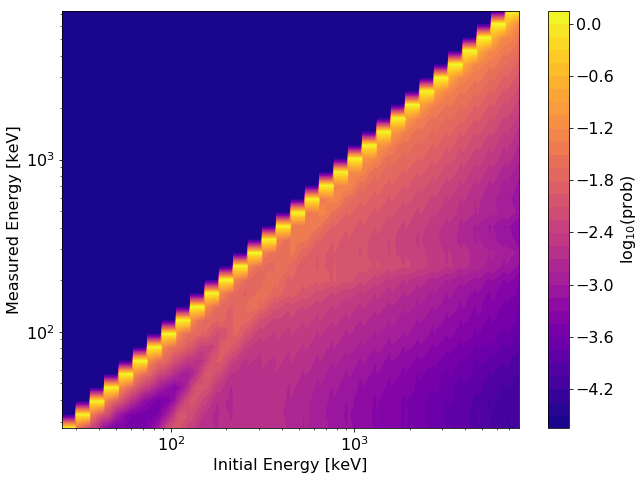

In [13]:
E_MEAN, EE = np.meshgrid(e_mean,ee)

plt.figure(figsize=(10.24,7.68))

plt.contourf(E_MEAN,EE,np.log10(matrix.T+matrix[matrix>0].min()),levels=40,cmap=plt.cm.plasma)
plt.ylabel('Measured Energy [keV]',fontsize=16)
plt.xlabel('Initial Energy [keV]',fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.colorbar(label='log$_{10}$(prob)')

<h3>Now definition of how the 'extracted' data points are fitted with the RMF and a parametrised spectrum:</h3>

In [14]:
def SPI_model_fit(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function, eval=False):
    """
    Returns:
    Negative normal-distributed log-likelihood for SPI data fitted with 
    arbitraty spectral model, accounting for the spectral response (default).
    Or, with eval=True, the output model in data space (in units of cnts/cm2/s/keV)
    
    Parameters:
    :param theta:     Array of to-be-fitted parameters used in combination with defined 'function'
    :param x:         Energy array (dim=(n,); in keV)
    :param y:         Differential flux array (dim=(n,); in cnts/cm2/s/keV)
    :param dx:        Energy bin sizes for x (dim=(n,); in keV)
    :param y_err:     Uncertainties on differential fluxes (one sigma values) (dim=(n,); in cnts/cm2/s/keV)
    :param rsp:       Response matrix that fits to the dimensions of x (and dx, y, y_err; dim=(m,n))
    :param e_lo:      Lower interpolated energy edges for response calculation(dim=(m,); in keV)
    :param e_hi:      Upper interpolated energy edges for response calculation(dim=(m,); in keV)  
    :param function:  String of named function in the current(!) notebook (may change later if individual functions are written in files or something)
    """
    
    # Now, same things as above:
    # Integrate model with Simpson's rule over the interpolated energy bins
    integrated_model = (e_hi-e_lo)/6.0*(globals()[function](e_lo,theta)+
                                        4*globals()[function]((e_lo+e_hi)/2.0,theta)+
                                        globals()[function](e_hi,theta))
    
    # Apply response matrix
    folded_model = np.dot(integrated_model,rsp)
 
    # Return to differential model
    folded_differential_model = folded_model / dx

    # Evaluate either chi2
    if eval==False:
        return -2*np.nansum((y-folded_differential_model)**2/y_err**2)
    # or return the folded model itself at a certain set of parameters
    else:
        return folded_differential_model
    
    
# add prior for each parameter to be fitted according to definition in 'function'
def ln_prior_SPI_spectrum(theta,prior):
    """
    this function assumes prior dictionaries of the shape:
    prior = {0: ('normal_prior',1e-4,1e-5,'Amplitude'),
             1: ('uniform_prior',-1.8,-1.6,'Index')}
    with the key being numbered sequentially
    then there is a tag for the prior function (normal, uniform, whatever you define else)
    then the prior values as defined in the functions
    and a name to identifiy later
    NO CHECKS FOR CONSISTENCY ARE PERFORMED
    """
    lnprior = 0.
    for p in range(len(theta)):
        lnprior += globals()[prior[p][0]](theta[p],prior[p][1:])
    return lnprior


def ln_posterior_SPI_spectrum(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function, prior):
    lp = ln_prior_SPI_spectrum(theta,prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + SPI_model_fit(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function)

<h3>Spectral fluxes in units of $\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$</h3>

In [15]:
flux = spec[2].data['DFLUX']
flux_err = spec[2].data['DFLUX_ERR']

<h3>Plot of GRB spectrum:</h3>

No handles with labels found to put in legend.


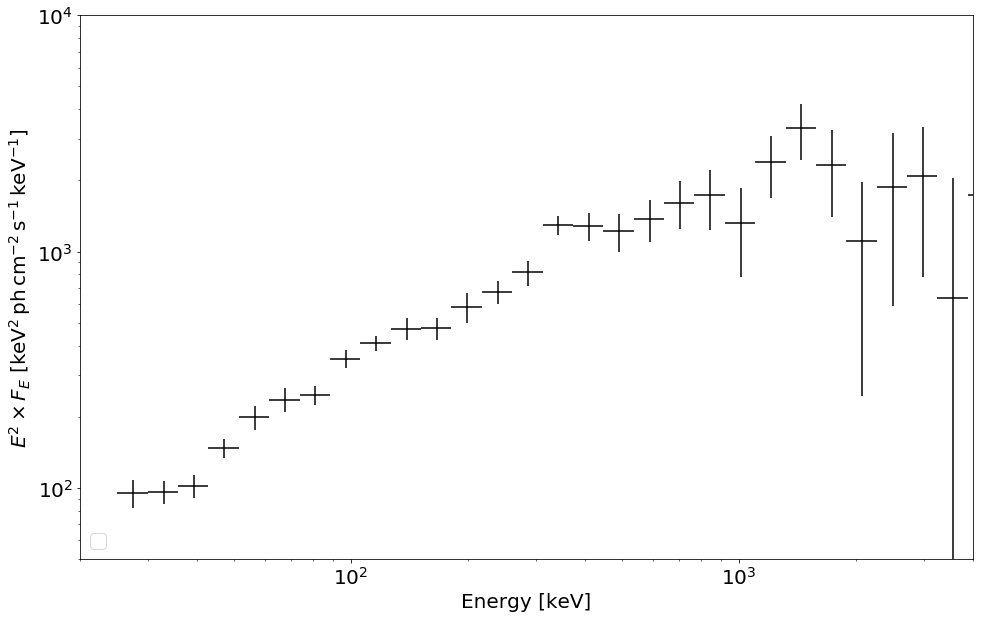

In [16]:
edx = 2

plt.figure(figsize=(16,10))

plt.errorbar(ee,
             flux*ee**edx,
             xerr=dee/2,
             yerr=flux_err*ee**edx,
             marker='',
             linestyle='')


plt.xscale('log')
plt.yscale('log')

plt.xlim(20,4000)


plt.xlabel('Energy [keV]',fontsize=20)
if edx == 1:
    plt.ylabel(r'$E \times F_E$ [$\mathrm{keV\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    plt.ylim(1e-1,1e1)
elif edx == 0:
    plt.ylabel(r'$F_E$ [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    plt.ylim(5e-5,5e-1)
elif edx == 2:
    plt.ylabel(r'$E^2 \times F_E$ [$\mathrm{keV^{2}\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    plt.ylim(5e1,1e4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.legend(fontsize=20,loc=3)

<h3>Fit with emcee:</h3>

<h3>Fitting a cutoff powerlaw here, because why not:</h3>

In [17]:
guess = np.array([5e-3,-1,1000])#,-3.])
n_par = len(guess)
fit_function = 'cutoff_powerlaw'

In [18]:
model = SPI_model_fit(guess,
                      ee,
                      np.zeros(len(ee)),
                      dee,
                      np.ones(len(ee)),
                      matrix,
                      e_lo,
                      e_hi,
                      function=fit_function,
                      eval=True)

<h3>Just overplotting initial guess:</h3>

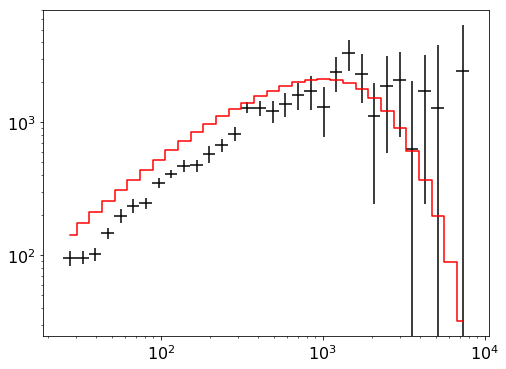

In [19]:
plt.errorbar(ee,
             flux*ee**edx,
             xerr=dee/2,
             yerr=flux_err*ee**edx,
             marker='',
             linestyle='')

plt.step(ee,model*ee**edx,where='mid')

plt.xscale('log')
plt.yscale('log')

<h3>Setting priors for parameters:</h3>

In [20]:
prior = {0: ('truncated_normal_prior',5e-3,1e-1,1e-6,1e1,r'$K_0$'),
         1: ('normal_prior',-1,5,r'$\alpha$'),
         2: ('truncated_normal_prior',1000,1000,20,4000,r'$E_C$')}#,
         #3: ('normal_prior',-3,5,r'$\beta$')}
 

<h3>Fit:</h3>

In [21]:
iters = 2000

ndim, nwalkers = n_par, n_par*5
pos = [guess + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

start = time.time()

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                ln_posterior_SPI_spectrum,
                                args=(ee,
                                      flux,
                                      dee,
                                      flux_err,
                                      matrix,
                                      e_lo,
                                      e_hi,
                                      fit_function,
                                      prior))

_ = sampler.run_mcmc(pos, iters, progress=True)
    
end = time.time()

# extract samples
samples = sampler.get_chain()
samplesf = sampler.flatchain

n_samples = iters#*nwalkers
n_walkers = nwalkers

burnin = int(0.5*n_samples)

ttime = end - start
print("Processing took {0:.1f} seconds".format(ttime))


print('\n')
print('Results:\n')


spec_params = np.zeros((n_par,7))


# formatting the table
row_format ='{:>10}' * 8

# first table row
print(row_format.format(*['Parameter','mean','std','0.15','15.85','50.00','84.15','99.85']))

for p in range(n_par):
    mean_val   = np.mean(samples[burnin:,:,p])
    std_val    = np.std(samples[burnin:,:,p])
    median_val = np.median(samples[burnin:,:,p])
    ub1_val    = np.percentile(samples[burnin:,:,p],50+68.3/2)
    lb1_val    = np.percentile(samples[burnin:,:,p],50-68.3/2)
    ub3_val    = np.percentile(samples[burnin:,:,p],50+99.73/2)
    lb3_val    = np.percentile(samples[burnin:,:,p],50-99.73/2)
    spec_params[p,:] = [mean_val,std_val,lb3_val,lb1_val,median_val,ub1_val,ub3_val]
    
    print(row_format.format(str(p)+':',
                        str('%1.2e' % mean_val),
                        str('%1.2e' % std_val),
                        str('%1.2e' % lb3_val),
                        str('%1.2e' % lb1_val),
                        str('%1.2e' % median_val),
                        str('%1.2e' % ub1_val),
                        str('%1.2e' % ub3_val)))

100%|██████████| 2000/2000 [00:04<00:00, 401.88it/s]

Processing took 5.0 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  3.40e-03  2.05e-04  2.88e-03  3.20e-03  3.39e-03  3.61e-03  4.16e-03
        1: -9.40e-01  2.24e-02 -1.00e+00 -9.62e-01 -9.41e-01 -9.18e-01 -8.65e-01
        2:  1.41e+03  1.32e+02  1.05e+03  1.28e+03  1.40e+03  1.54e+03  1.85e+03


<h3>Chains:</h3>

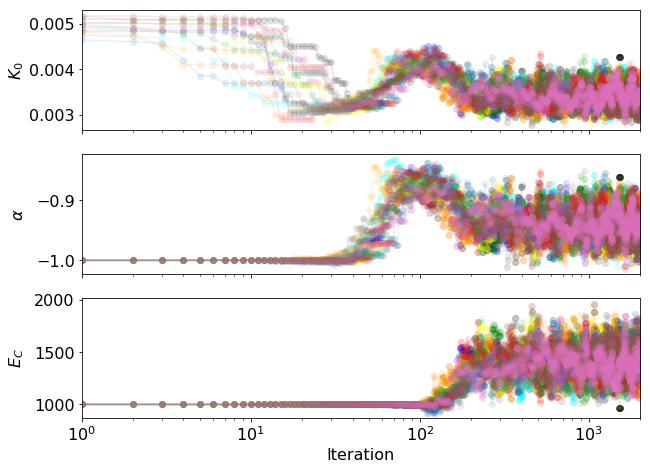

In [22]:
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2.5), sharex=True)
samples = sampler.get_chain()
labels = [r'$K_0$', r'$\alpha$', r'$E_C$', r'$\beta$']
#truths = [C0,alpha]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples)),samples[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samples))
    #ax.plot([1,len(samples)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

<h3>Posteriors:</h3>

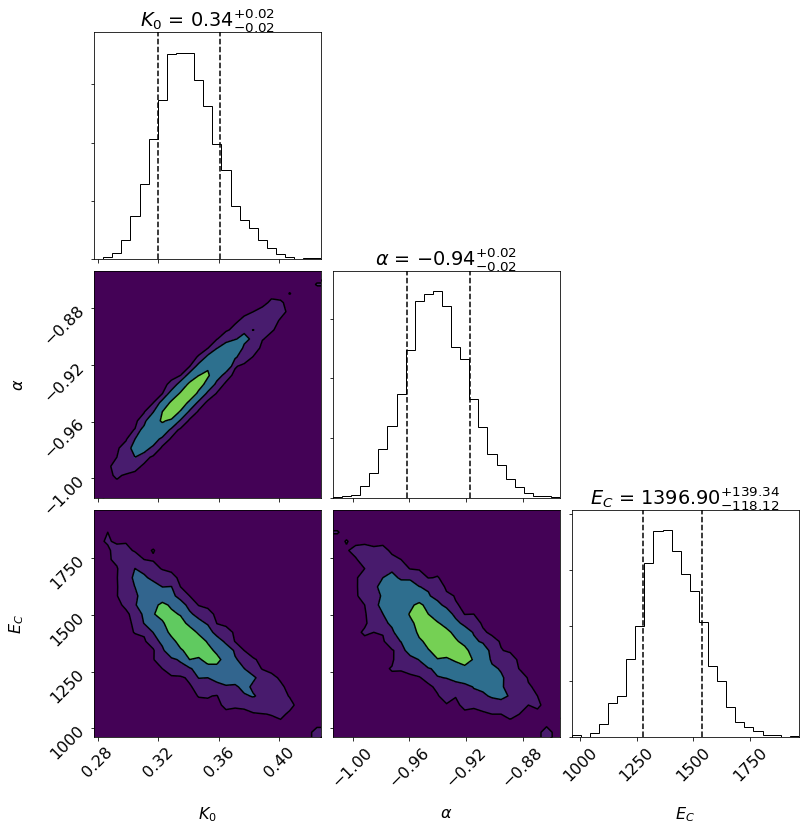

In [23]:
scl = [1e2,1,1]
samplesf = sampler.flatchain
sigma = 68.3
fig = corner.corner(samplesf[burnin*n_walkers:,:]*scl,
                    labels=labels,
                    #truths=np.array([C0,alpha])*scl,
                    quantiles=(50+sigma/np.array([-2,+2]))/100.,
                    show_titles=True,
                    bins=25,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.viridis, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    truth_color='orange')
fig.set_size_inches(12,12)

<h3>Calculating posterior model for data space and model space from the last 250 iterations:</h3>

In [24]:
n_e = len(ee)

# how many samples to use for plotting and calculation of posterior model
n_use = 250
# data space
n_plot_samples = n_walkers*n_use
y_models = np.zeros((n_e,n_plot_samples))


# where to evaluate model
x_model = np.logspace(np.log10(10),np.log10(10000),500)
N_model = len(x_model)
y_modelsm = np.zeros((N_model,n_plot_samples))

last_x_samples = iters-n_use

print(n_walkers*last_x_samples,n_walkers*last_x_samples+n_plot_samples)

for i in tqdm(range(n_walkers*last_x_samples,n_walkers*last_x_samples+n_plot_samples),'Loop over samples:'):
    #i = p - n_walkers*last_x_samples
    y_models[:,i-n_walkers*last_x_samples] =SPI_model_fit(samplesf[i,:],
                                                          ee,
                                                          np.zeros(len(ee)),
                                                          dee,
                                                          np.ones(len(ee)),
                                                          matrix,
                                                          e_lo,
                                                          e_hi,
                                                          function=fit_function,
                                                          eval=True)


    y_modelsm[:,i-n_walkers*last_x_samples] = globals()[fit_function](x_model,samplesf[i,:])


26250 30000


<h3>Plotting everything together and residuals:</h3>

(-5, 5)

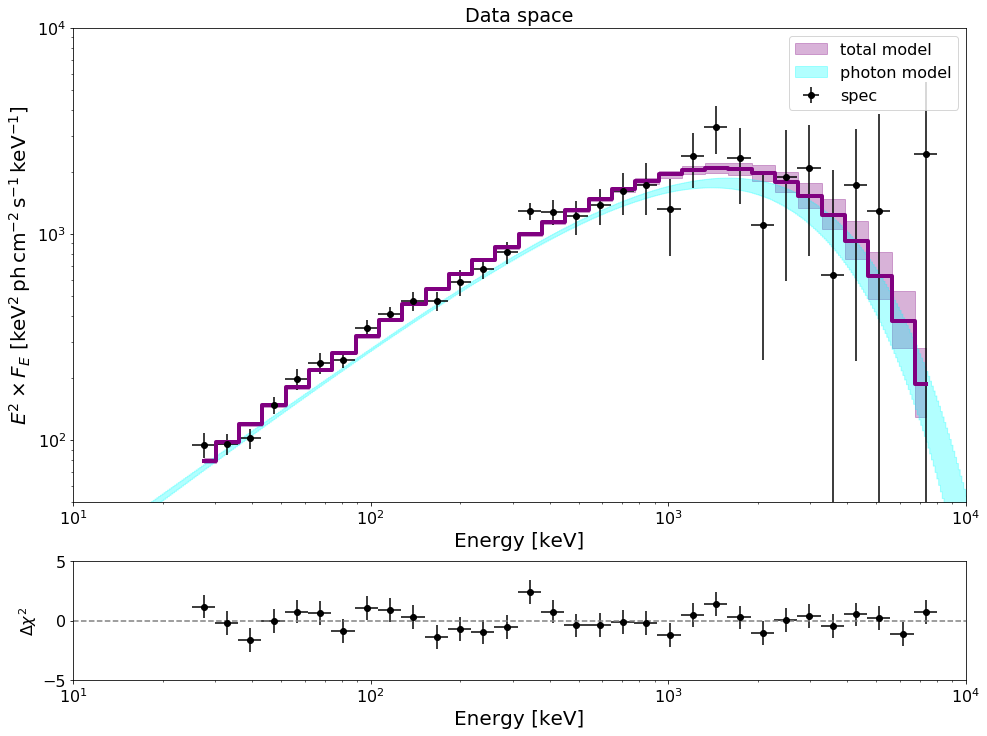

In [25]:
edx = 2

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,12),
                       gridspec_kw={'height_ratios':[4,1]})

ax[0].errorbar(ee,
             flux*ee**edx,
             xerr=dee/2,
             yerr=flux_err*ee**edx,
             color='black',marker='o',linestyle='',
             label='spec')

level = 68.3
ax[0].fill_between(ee,
                np.percentile(y_models, 50 - 0.5*level, axis=1 )*ee**edx,
                np.percentile(y_models, 50 + 0.5*level, axis=1 )*ee**edx,
                color='purple',alpha=0.3,step='mid',label='total model')


ax[0].fill_between(x_model,
                np.percentile(y_modelsm, 50 - 0.5*level, axis=1 )*x_model**edx,
                np.percentile(y_modelsm, 50 + 0.5*level, axis=1 )*x_model**edx,
                color='cyan',alpha=0.3,step='mid',label='photon model')

fit_model = np.median(y_models,axis=1)
ax[0].step(ee,fit_model*ee**edx,linewidth=4,color='purple',where='mid')



ax[0].set_xlim(10,10000)
ax[1].set_xlim(10,10000)


ax[0].set_xlabel('Energy [keV]',fontsize=20)
if edx == 1:
    ax[0].set_ylabel(r'$E \times F_E$ [$\mathrm{keV\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(1e-1,1e1)
elif edx == 0:
    ax[0].set_ylabel(r'$F_E$ [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(5e-5,5e-1)
elif edx == 2:
    ax[0].set_ylabel(r'$E^2 \times F_E$ [$\mathrm{keV^{2}\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(5e1,1e4)


ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].step(ee,DataSpace_model3,color='cyan',linewidth=4,where='mid',label='True model')

ax[0].set_title('Data space')
ax[0].legend()

#ax[0].set_xticks([])

ax[1].set_xlabel('Energy [keV]',fontsize=20)

ax[1].errorbar(ee,
             (flux-fit_model)/(flux_err),
             xerr=dee/2,
             yerr=flux_err/flux_err,
             color='black',marker='o',linestyle='',
             label='residuals')
ax[1].set_xscale('log')
ax[1].axhline(0,linestyle='--',color='gray')
ax[1].set_ylabel(r'$\Delta \chi^2$')

ax[1].set_ylim(-5,5)

<h3>The photon model appears 'below' the extracted data points because the photopeak response puts 'too much flux' into the bins. This 'pseudo-efficiency' is corrected by re-distributing the fluxes.</h3>

<h3>And trying to fit a Band function:</h3>

In [26]:
guess = np.array([5e-2,-1,1000,-4.])
n_par = len(guess)
from spectral_shapes import band_function100
# pivot energy at 100 keV
fit_function = 'band_function100'

In [27]:
model = SPI_model_fit(guess,
                      ee,
                      np.zeros(len(ee)),
                      dee,
                      np.ones(len(ee)),
                      matrix,
                      e_lo,
                      e_hi,
                      function=fit_function,
                      eval=True)

<h3>Just overplotting initial guess:</h3>

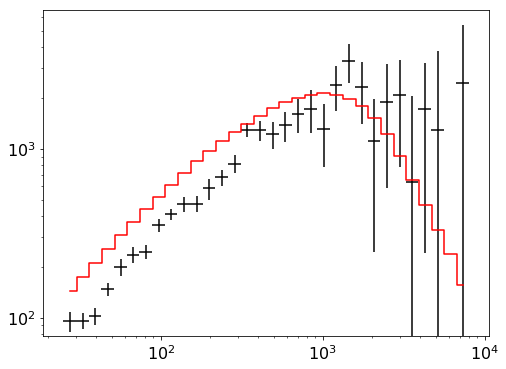

In [28]:
plt.errorbar(ee,
             flux*ee**edx,
             xerr=dee/2,
             yerr=flux_err*ee**edx,
             marker='',
             linestyle='')

plt.step(ee,model*ee**edx,where='mid')

plt.xscale('log')
plt.yscale('log')

<h3>Setting priors for parameters:</h3>

In [29]:
prior = {0: ('truncated_normal_prior',5e-2,1e-1,1e-6,1e1,r'$K_0$'),
         1: ('truncated_normal_prior',-1,1,-4,10,r'$\alpha$'),
         2: ('truncated_normal_prior',1000,1000,25,8000,r'$E_C$'),
         3: ('truncated_normal_prior',-4,2,-10,-2,r'$\beta$')}
 

<h3>Fit:</h3>

In [30]:
iters = 2000

ndim, nwalkers = n_par, n_par*5
pos = [guess + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

start = time.time()

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                ln_posterior_SPI_spectrum,
                                args=(ee,
                                      flux,
                                      dee,
                                      flux_err,
                                      matrix,
                                      e_lo,
                                      e_hi,
                                      fit_function,
                                      prior))

_ = sampler.run_mcmc(pos, iters, progress=True)
    
end = time.time()

# extract samples
samples = sampler.get_chain()
samplesf = sampler.flatchain

n_samples = iters#*nwalkers
n_walkers = nwalkers

burnin = int(0.5*n_samples)

ttime = end - start
print("Processing took {0:.1f} seconds".format(ttime))


print('\n')
print('Results:\n')


spec_params = np.zeros((n_par,7))


# formatting the table
row_format ='{:>10}' * 8

# first table row
print(row_format.format(*['Parameter','mean','std','0.15','15.85','50.00','84.15','99.85']))

for p in range(n_par):
    mean_val   = np.mean(samples[burnin:,:,p])
    std_val    = np.std(samples[burnin:,:,p])
    median_val = np.median(samples[burnin:,:,p])
    ub1_val    = np.percentile(samples[burnin:,:,p],50+68.3/2)
    lb1_val    = np.percentile(samples[burnin:,:,p],50-68.3/2)
    ub3_val    = np.percentile(samples[burnin:,:,p],50+99.73/2)
    lb3_val    = np.percentile(samples[burnin:,:,p],50-99.73/2)
    spec_params[p,:] = [mean_val,std_val,lb3_val,lb1_val,median_val,ub1_val,ub3_val]
    
    print(row_format.format(str(p)+':',
                        str('%1.2e' % mean_val),
                        str('%1.2e' % std_val),
                        str('%1.2e' % lb3_val),
                        str('%1.2e' % lb1_val),
                        str('%1.2e' % median_val),
                        str('%1.2e' % ub1_val),
                        str('%1.2e' % ub3_val)))

100%|██████████| 2000/2000 [00:10<00:00, 182.80it/s]

Processing took 11.0 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  2.96e-02  4.93e-04  2.80e-02  2.91e-02  2.96e-02  3.01e-02  3.12e-02
        1: -9.39e-01  2.25e-02 -9.99e-01 -9.62e-01 -9.40e-01 -9.16e-01 -8.71e-01
        2:  1.40e+03  1.34e+02  1.03e+03  1.26e+03  1.40e+03  1.53e+03  1.86e+03
        3: -4.64e+00  1.53e+00 -9.56e+00 -6.28e+00 -4.45e+00 -3.00e+00 -2.08e+00


<h3>Chains:</h3>

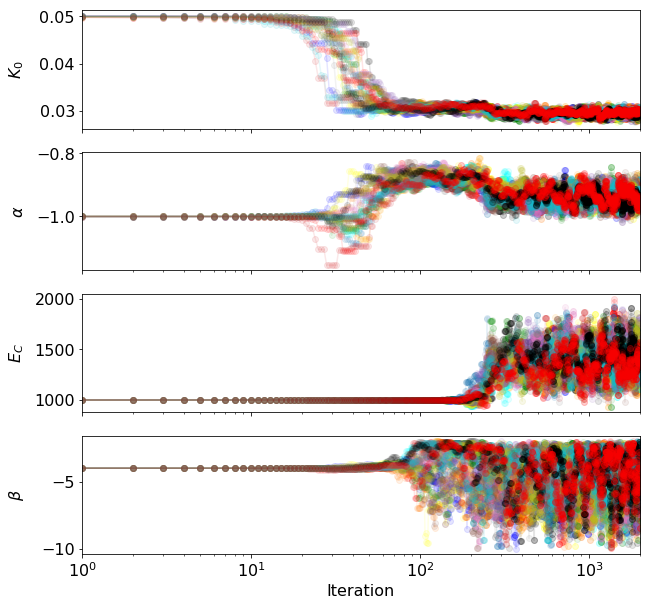

In [31]:
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2.5), sharex=True)
samples = sampler.get_chain()
labels = [r'$K_0$', r'$\alpha$', r'$E_C$', r'$\beta$']
#truths = [C0,alpha]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples)),samples[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samples))
    #ax.plot([1,len(samples)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

<h3>Posteriors:</h3>

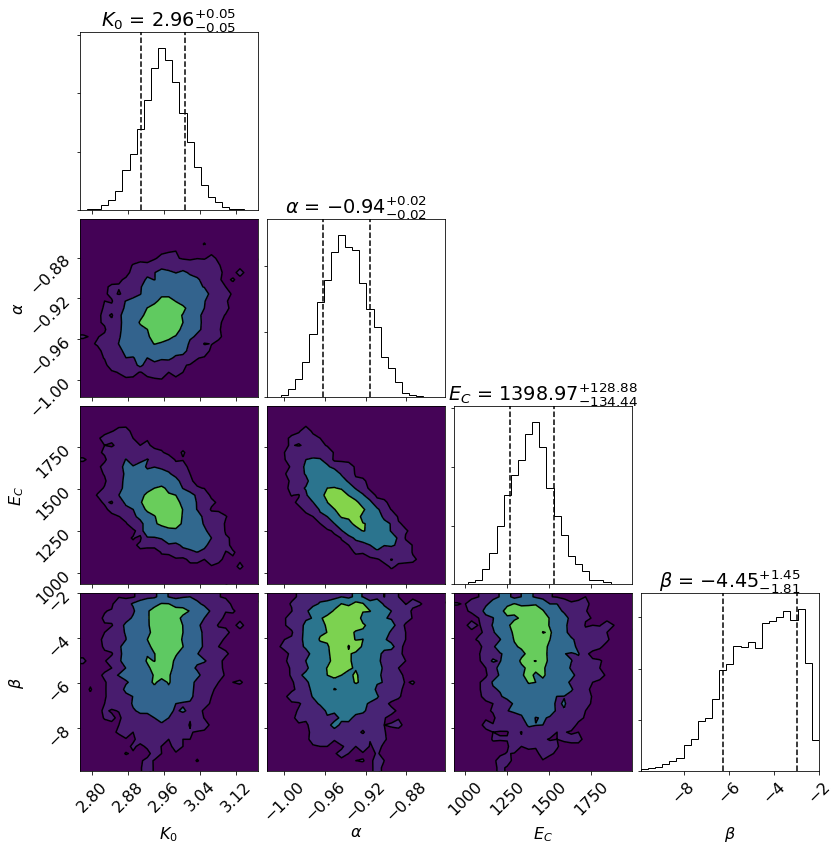

In [32]:
scl = [1e2,1,1,1]
samplesf = sampler.flatchain
sigma = 68.3
fig = corner.corner(samplesf[burnin*n_walkers:,:]*scl,
                    labels=labels,
                    #truths=np.array([C0,alpha])*scl,
                    quantiles=(50+sigma/np.array([-2,+2]))/100.,
                    show_titles=True,
                    bins=25,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.viridis, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    truth_color='orange')
fig.set_size_inches(12,12)

<h3>Calculating posterior model for data space and model space from the last 250 iterations:</h3>

In [33]:
n_e = len(ee)

# how many samples to use for plotting and calculation of posterior model
n_use = 250
# data space
n_plot_samples = n_walkers*n_use
y_models = np.zeros((n_e,n_plot_samples))


# where to evaluate model
x_model = np.logspace(np.log10(10),np.log10(10000),500)
N_model = len(x_model)
y_modelsm = np.zeros((N_model,n_plot_samples))

last_x_samples = iters-n_use

print(n_walkers*last_x_samples,n_walkers*last_x_samples+n_plot_samples)

for i in tqdm(range(n_walkers*last_x_samples,n_walkers*last_x_samples+n_plot_samples),'Loop over samples:'):
    #i = p - n_walkers*last_x_samples
    y_models[:,i-n_walkers*last_x_samples] =SPI_model_fit(samplesf[i,:],
                                                          ee,
                                                          np.zeros(len(ee)),
                                                          dee,
                                                          np.ones(len(ee)),
                                                          matrix,
                                                          e_lo,
                                                          e_hi,
                                                          function=fit_function,
                                                          eval=True)


    y_modelsm[:,i-n_walkers*last_x_samples] = globals()[fit_function](x_model,samplesf[i,:])


35000 40000


<h3>Plotting everything together and residuals:</h3>

(-5, 5)

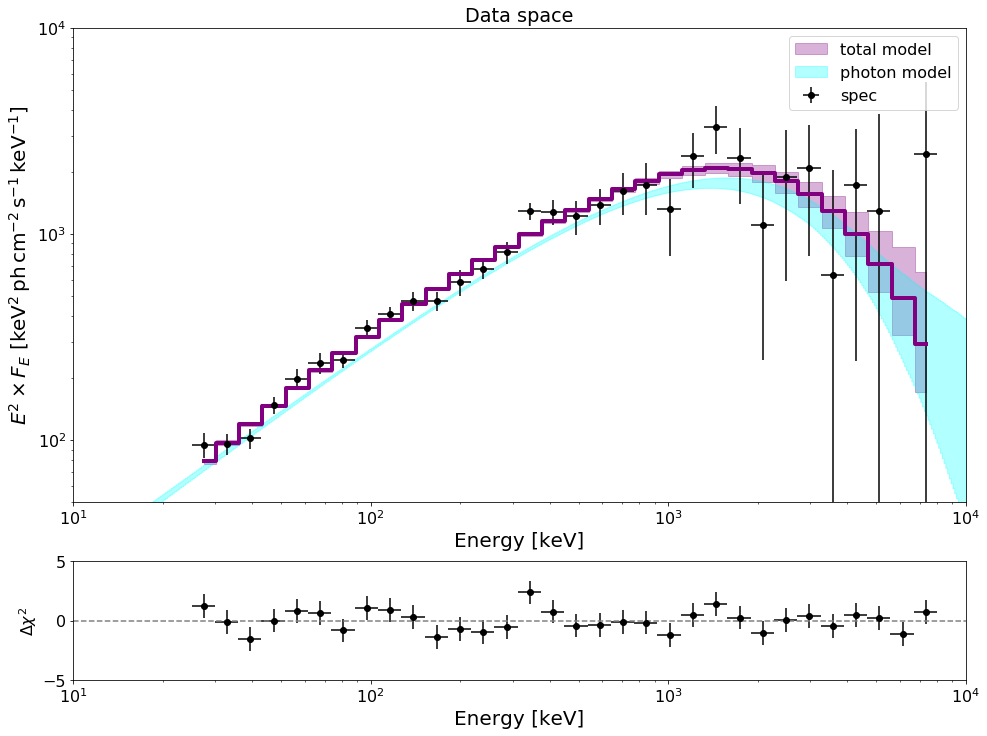

In [34]:
edx = 2

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,12),
                       gridspec_kw={'height_ratios':[4,1]})

ax[0].errorbar(ee,
             flux*ee**edx,
             xerr=dee/2,
             yerr=flux_err*ee**edx,
             color='black',marker='o',linestyle='',
             label='spec')

level = 68.3
ax[0].fill_between(ee,
                np.percentile(y_models, 50 - 0.5*level, axis=1 )*ee**edx,
                np.percentile(y_models, 50 + 0.5*level, axis=1 )*ee**edx,
                color='purple',alpha=0.3,step='mid',label='total model')


ax[0].fill_between(x_model,
                np.percentile(y_modelsm, 50 - 0.5*level, axis=1 )*x_model**edx,
                np.percentile(y_modelsm, 50 + 0.5*level, axis=1 )*x_model**edx,
                color='cyan',alpha=0.3,step='mid',label='photon model')

fit_model = np.median(y_models,axis=1)
ax[0].step(ee,fit_model*ee**edx,linewidth=4,color='purple',where='mid')



ax[0].set_xlim(10,10000)
ax[1].set_xlim(10,10000)


ax[0].set_xlabel('Energy [keV]',fontsize=20)
if edx == 1:
    ax[0].set_ylabel(r'$E \times F_E$ [$\mathrm{keV\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(1e-1,1e1)
elif edx == 0:
    ax[0].set_ylabel(r'$F_E$ [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(5e-5,5e-1)
elif edx == 2:
    ax[0].set_ylabel(r'$E^2 \times F_E$ [$\mathrm{keV^{2}\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    ax[0].set_ylim(5e1,1e4)


ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].step(ee,DataSpace_model3,color='cyan',linewidth=4,where='mid',label='True model')

ax[0].set_title('Data space')
ax[0].legend()

#ax[0].set_xticks([])

ax[1].set_xlabel('Energy [keV]',fontsize=20)

ax[1].errorbar(ee,
             (flux-fit_model)/(flux_err),
             xerr=dee/2,
             yerr=flux_err/flux_err,
             color='black',marker='o',linestyle='',
             label='residuals')
ax[1].set_xscale('log')
ax[1].axhline(0,linestyle='--',color='gray')
ax[1].set_ylabel(r'$\Delta \chi^2$')

ax[1].set_ylim(-5,5)